In [1]:
import pandas as pd
import numpy as np
import seaborn as sns

from dpks import QuantMatrix

In [2]:
ms_data = pd.read_csv(
    "../0_data/proteins_train_filtered.tsv"
    , sep="\t"
)

In [3]:
design_matrix_otrain = pd.read_csv(
    "../0_data/design_matrix_train.tsv",
    sep='\t'
)

In [4]:
# skin_and_soft_tissue_infection
# blood_stream_infection
# abdominal_infection
# skin_and_soft_tissue_infection
# pneumonia

In [5]:
def preprocess_design_matrix(design_matrix):

    design_matrix = design_matrix[design_matrix['verified_infection'] == 1]

    design_matrix = design_matrix[
        (design_matrix['urinary_tract_infection'] == 1) |
        #(design_matrix['blood_stream_infection'] == 1) |
        (design_matrix['abdominal_infection'] == 1) |
        (design_matrix['skin_and_soft_tissue_infection'] == 1) |
        (design_matrix['pneumonia'] == 1)
    ]

    design_matrix['group'] = np.where(
        design_matrix['skin_and_soft_tissue_infection'] == 1, 2, 1
    )

    design_matrix['sample'] = design_matrix['injection']

    return design_matrix

In [6]:
def preprocess_data(raw_data, design_matrix):

    quant_matrix = QuantMatrix(
        quantification_file=raw_data[['Protein'] + [sample for sample in design_matrix['sample'].values]].copy(),
        design_matrix_file=design_matrix,
        annotation_fasta_file="../0_data/2023-04-24-UP000005640.fas"
    )

    quant_data = quant_matrix.to_df()
    
    quant_data = quant_data[~((quant_data["ProteinLabel"].str.startswith("HV")) | (quant_data["ProteinLabel"].str.startswith("LV")) | quant_data["ProteinLabel"].str.startswith("KV"))]
    quant_data = quant_data[~quant_data["ProteinLabel"].str.startswith("IG")]
    quant_data = quant_data[~((quant_data["ProteinLabel"] == "HBA_HUMAN") | (quant_data["ProteinLabel"] == "HBB_HUMAN") | (quant_data["ProteinLabel"] == "HBD_HUMAN") | (quant_data["ProteinLabel"] == "HEMO_HUMAN"))]

    quant_matrix = QuantMatrix(
        quantification_file=quant_data,
        design_matrix_file=design_matrix,
        annotation_fasta_file="../0_data/2023-04-24-UP000005640.fas"
    )

    return quant_matrix     


# Model Training

In [7]:
design_matrix_train = preprocess_design_matrix(design_matrix_otrain.copy())

<Axes: xlabel='skin_and_soft_tissue_infection', ylabel='Count'>

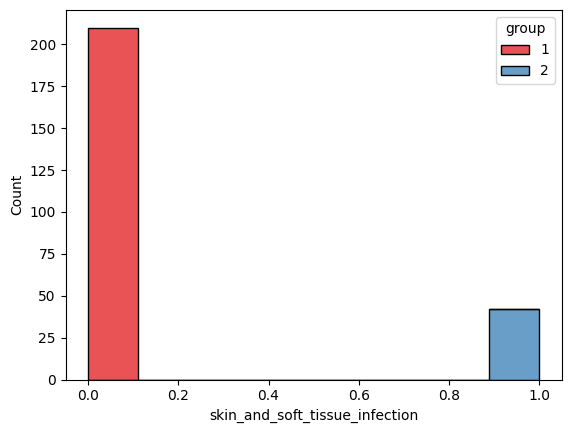

In [8]:
sns.histplot(
    design_matrix_train,
    x="skin_and_soft_tissue_infection",
    hue="group",
    palette="Set1",
    multiple="stack"
)

In [9]:
design_matrix_train['group'].value_counts()

group
1    210
2     42
Name: count, dtype: int64

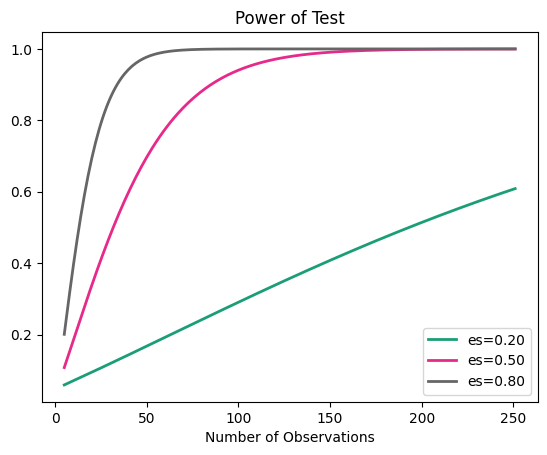

In [10]:
from statsmodels.stats.power import TTestIndPower
import matplotlib.pyplot as plt

# parameters for power analysis
effect_sizes = np.array([0.2, 0.5, 0.8])
sample_sizes = np.array(range(5, design_matrix_train.shape[0]))


analysis = TTestIndPower()

analysis.plot_power(dep_var='nobs', nobs=sample_sizes, effect_size=effect_sizes)
plt.show()

In [11]:
quant_matrix_train = preprocess_data(ms_data, design_matrix=design_matrix_train)

In [12]:
quant_matrix_train = quant_matrix_train.compare(
    method="linregress",
    comparisons=(2,1),
    min_samples_per_group=2,
    level="protein",
    multiple_testing_correction_method="fdr_tsbh"
)

In [13]:
quant_matrix_train.write("de_results/sst_de_proteins.tsv")

In [14]:
quant_matrix_de = quant_matrix_train.to_df()

<Axes: xlabel='Log2FoldChange2-1', ylabel='-Log10CorrectedPValue2-1'>

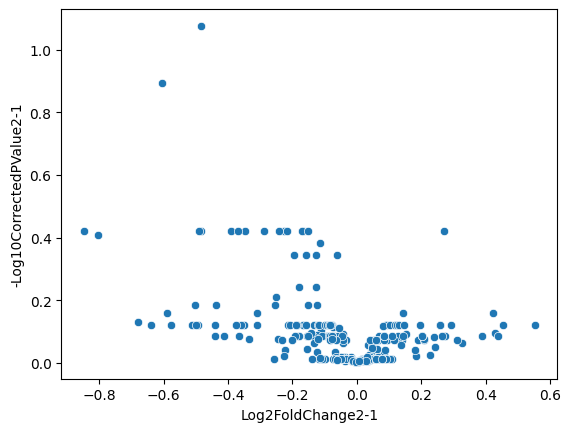

In [15]:
sns.scatterplot(
    data=quant_matrix_de,
    x="Log2FoldChange2-1",
    y="-Log10CorrectedPValue2-1"
)

In [16]:
qm_filtered = (
    
    QuantMatrix(
        quantification_file=quant_matrix_de,
        design_matrix_file=design_matrix_train
    )
    
)

In [17]:
training_data, y = qm_filtered.to_ml(feature_column="ProteinLabel")

In [18]:
protein_columns = training_data.columns.to_list()

In [19]:
len(protein_columns)

287

In [20]:
from sklearn.preprocessing import StandardScaler, LabelBinarizer
from sklearn.impute import SimpleImputer

X = training_data.copy()

protein_scaler = StandardScaler()

X[protein_columns] = protein_scaler.fit_transform(X[protein_columns])

X = X.copy()

In [21]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import BaggingClassifier


protein_clf = LogisticRegression(
    random_state=42,
    #penalty="l1",
    class_weight="balanced",
    #C=0.1,
    #solver="liblinear",
    max_iter=1000
)

# protein_clf = BaggingClassifier(
#     estimator=protein_clf
# )

In [22]:
y['label'].value_counts()

label
0    210
1     42
Name: count, dtype: int64

In [23]:
from sklearn.utils.class_weight import compute_class_weight, compute_sample_weight


class_weight = compute_class_weight(
    class_weight="balanced",
    classes=np.unique(y.values.ravel()),
    y=y.values.ravel()
)

class_weight = dict(zip(np.unique(y.values.ravel()), class_weight))

class_weight

{0: 0.6, 1: 3.0}

In [24]:
# sample_weight = compute_sample_weight(
#     class_weight=class_weight,
#     y=y.values.ravel()
# )

In [25]:
from mrmr import mrmr_classif
selected_proteins = mrmr_classif(X=X[protein_columns], y=y.values.ravel(), K=50)

100%|██████████| 50/50 [00:21<00:00,  2.36it/s]


In [26]:
selected_proteins

['CATD_HUMAN',
 'PON3_HUMAN',
 'K2C1_HUMAN',
 'CO6A1_HUMAN',
 'TRY1_HUMAN',
 'H4_HUMAN',
 'COMP_HUMAN',
 'THBG_HUMAN',
 'MA2A1_HUMAN',
 'PZP_HUMAN',
 'BIP_HUMAN',
 'SHBG_HUMAN',
 'VTDB_HUMAN',
 'A2GL_HUMAN',
 'ICAM1_HUMAN',
 'FCG3A_HUMAN',
 'ZPI_HUMAN',
 'IBP2_HUMAN',
 'TBA4A_HUMAN',
 'C1R_HUMAN',
 'A2MG_HUMAN',
 'COL10_HUMAN',
 'TIMP1_HUMAN',
 'EIF3M_HUMAN',
 'LYAM1_HUMAN',
 'PCSK9_HUMAN',
 'LIRB1_HUMAN',
 'PRDX2_HUMAN',
 'HGFA_HUMAN',
 'ITIH3_HUMAN',
 'FHR4_HUMAN',
 'FIBG_HUMAN',
 'C163A_HUMAN',
 'CD14_HUMAN',
 'MBL2_HUMAN',
 'ALDOB_HUMAN',
 'THIO_HUMAN',
 'PDLI1_HUMAN',
 'HS90A_HUMAN',
 'CO9_HUMAN',
 'LAMP2_HUMAN',
 'RNAS4_HUMAN',
 'PSPB_HUMAN',
 'CRP_HUMAN',
 'MA1A1_HUMAN',
 'TSP1_HUMAN',
 'SAA4_HUMAN',
 'MUC18_HUMAN',
 'SODC_HUMAN',
 'F13B_HUMAN']

In [27]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import BaggingClassifier, HistGradientBoostingClassifier


protein_clf = LogisticRegression(
    class_weight=class_weight,
    random_state=42
)

In [28]:
from sklearn.model_selection import cross_val_score, StratifiedKFold, cross_validate

cv = StratifiedKFold(3)
eval_result = cross_validate(
    protein_clf, X[selected_proteins], y.values.ravel(), scoring=("recall", "precision", "accuracy", "balanced_accuracy"), cv=cv, #
)
eval_result['test_recall'].mean(), eval_result['test_precision'].mean(), eval_result['test_accuracy'].mean(), eval_result['test_balanced_accuracy'].mean()

(0.35714285714285715,
 0.32275132275132273,
 0.7777777777777778,
 0.6095238095238095)

In [29]:
from dpks.interpretation import BootstrapInterpreter

protein_interpreter = BootstrapInterpreter(
    n_iterations=100,
    feature_names=selected_proteins,
    downsample_background=True,
    shuffle_iterations=100
)

In [30]:
protein_interpreter.fit(X[selected_proteins].values, y.values.ravel(), protein_clf)

In [31]:
protein_importances = protein_interpreter.results_.sort_values("mean_importance", ascending=False)

In [32]:
protein_importances.head(20)

,feature,iteration_0_importance,iteration_0_rank,iteration_1_importance,iteration_1_rank,iteration_2_importance,iteration_2_rank,iteration_3_importance,iteration_3_rank,iteration_4_importance,...,iteration_98_importance,iteration_98_rank,iteration_99_importance,iteration_99_rank,mean_importance,median_importance,stdev_importance,mean_rank,median_rank,stdev_rank
47,MUC18_HUMAN,0.404085,21.0,0.979603,2.0,0.462237,13.0,1.000000,1.0,1.000000,...,0.605961,9.0,1.000000,1.0,0.705757,0.718703,0.274824,8.92,5.0,10.447251
6,COMP_HUMAN,0.750130,5.0,0.414257,24.0,0.904414,3.0,0.896226,2.0,0.136877,...,0.139123,35.0,0.691177,5.0,0.571847,0.571908,0.270704,12.47,8.0,11.518501
37,PDLI1_HUMAN,0.571257,11.0,0.528758,15.0,0.391776,18.0,0.336771,15.0,0.837158,...,0.909675,3.0,0.443886,10.0,0.501776,0.485432,0.265802,15.87,11.5,13.341403
7,THBG_HUMAN,0.876763,2.0,0.392180,25.0,0.951230,2.0,0.257629,21.0,0.115771,...,0.877527,4.0,0.905671,3.0,0.465768,0.474649,0.283195,18.01,13.0,14.141061
0,CATD_HUMAN,0.156365,35.0,0.487423,20.0,0.415028,16.0,0.094875,37.0,0.408707,...,0.819193,5.0,0.637843,6.0,0.462377,0.464029,0.271618,17.38,13.5,14.308139
13,A2GL_HUMAN,0.441320,20.0,0.613622,11.0,0.100688,40.0,0.073503,41.0,0.820009,...,1.000000,1.0,0.100141,37.0,0.459025,0.414175,0.280169,17.98,16.0,13.371899
17,IBP2_HUMAN,0.712796,6.0,1.000000,1.0,0.211985,30.0,0.199397,24.0,0.495647,...,0.679513,7.0,0.397776,12.0,0.434245,0.441859,0.237753,18.40,15.0,13.306792
41,RNAS4_HUMAN,0.154619,36.0,0.787985,3.0,0.583635,10.0,0.090463,38.0,0.435217,...,0.785061,6.0,0.088251,41.0,0.420731,0.395942,0.255841,19.70,17.5,13.528496
8,MA2A1_HUMAN,0.046854,45.0,0.389758,27.0,0.008991,50.0,0.011412,48.0,0.156051,...,0.254230,23.0,0.914914,2.0,0.418544,0.355273,0.303256,21.59,22.0,15.187112
20,A2MG_HUMAN,0.543688,13.0,0.616036,10.0,0.220637,28.0,0.609294,4.0,0.091636,...,0.342317,16.0,0.260121,22.0,0.394781,0.361667,0.261020,21.38,18.0,14.960406


In [33]:
selected_proteins = protein_importances.head(10)['feature'].to_list()

In [34]:
from dpks.interpretation import Classifier


protein_clf = Classifier(protein_clf)

In [35]:
selected_features = selected_proteins[:10]

In [36]:
for feature in selected_features:

    print(feature)

MUC18_HUMAN
COMP_HUMAN
PDLI1_HUMAN
THBG_HUMAN
CATD_HUMAN
A2GL_HUMAN
IBP2_HUMAN
RNAS4_HUMAN
MA2A1_HUMAN
A2MG_HUMAN


In [37]:
protein_clf = LogisticRegression(
    class_weight=class_weight,
    random_state=42
)

In [38]:
from sklearn.model_selection import cross_val_score, StratifiedKFold, cross_validate

cv = StratifiedKFold(3, shuffle=True, random_state=42)
eval_result = cross_validate(
    protein_clf, X[selected_features], y.values.ravel(), scoring=("recall", "precision", "accuracy", "balanced_accuracy"), cv=cv, 
)
eval_result['test_recall'].mean(), eval_result['test_precision'].mean(), eval_result['test_accuracy'].mean(), eval_result['test_balanced_accuracy'].mean()

(0.7857142857142857, 0.38047138047138046, 0.75, 0.7642857142857142)

In [39]:
cv = StratifiedKFold(3, shuffle=True, random_state=42)
eval_result = cross_validate(
    protein_clf, X[protein_columns], y.values.ravel(), scoring=("recall", "precision", "accuracy", "balanced_accuracy"), cv=cv, 
)
eval_result['test_recall'].mean(), eval_result['test_precision'].mean(), eval_result['test_accuracy'].mean(), eval_result['test_balanced_accuracy'].mean()

(0.30952380952380953,
 0.32106782106782106,
 0.7777777777777778,
 0.5904761904761905)

In [40]:
from dpks.interpretation import BootstrapInterpreter

final_protein_interpreter = BootstrapInterpreter(
    n_iterations=100,
    feature_names=selected_features,
    downsample_background=True,
    shuffle_iterations=100
)

In [41]:
final_protein_interpreter.fit(X[selected_features].values, y.values.ravel(), protein_clf)

In [42]:
final_protein_importances = final_protein_interpreter.results_.sort_values("mean_importance", ascending=False)

In [43]:
final_protein_importances

,feature,iteration_0_importance,iteration_0_rank,iteration_1_importance,iteration_1_rank,iteration_2_importance,iteration_2_rank,iteration_3_importance,iteration_3_rank,iteration_4_importance,...,iteration_98_importance,iteration_98_rank,iteration_99_importance,iteration_99_rank,mean_importance,median_importance,stdev_importance,mean_rank,median_rank,stdev_rank
1,COMP_HUMAN,1.000000,1.0,0.275286,10.0,1.000000,1.0,0.441932,4.0,0.565769,...,0.044070,10.0,0.859723,2.0,0.660098,0.672403,0.314052,4.15,3.0,3.176222
9,A2MG_HUMAN,0.551986,4.0,0.707370,4.0,0.296495,6.0,1.000000,1.0,0.076055,...,0.409146,7.0,0.023116,10.0,0.630611,0.661956,0.292713,4.20,4.0,2.752409
3,THBG_HUMAN,0.624531,3.0,0.379442,8.0,0.216406,7.0,0.504284,2.0,0.341267,...,1.000000,1.0,1.000000,1.0,0.583792,0.621626,0.307979,4.47,4.0,2.713435
6,IBP2_HUMAN,0.717071,2.0,0.755599,3.0,0.317466,5.0,0.258925,6.0,1.000000,...,0.544795,5.0,0.353374,6.0,0.538778,0.526385,0.273605,5.00,5.0,2.474108
7,RNAS4_HUMAN,0.289865,7.0,0.847784,2.0,0.360797,4.0,0.232781,7.0,0.621679,...,0.682687,4.0,0.223411,7.0,0.481709,0.447625,0.260516,5.43,5.5,2.535625
0,MUC18_HUMAN,0.001423,10.0,0.601589,5.0,0.464764,2.0,0.503143,3.0,0.777546,...,0.436679,6.0,0.443658,5.0,0.467586,0.469655,0.285297,5.66,6.0,2.861165
4,CATD_HUMAN,0.425849,5.0,0.291994,9.0,0.369337,3.0,0.035493,10.0,0.331520,...,0.318368,8.0,0.676599,3.0,0.419409,0.384436,0.253940,6.01,6.0,2.797889
5,A2GL_HUMAN,0.041454,9.0,1.000000,1.0,0.117162,8.0,0.104956,8.0,0.692013,...,0.820938,3.0,0.212351,8.0,0.405980,0.356235,0.266075,6.38,7.0,2.635346
8,MA2A1_HUMAN,0.368575,6.0,0.489279,7.0,0.109296,9.0,0.061675,9.0,0.266328,...,0.143711,9.0,0.546713,4.0,0.379194,0.309974,0.288509,6.65,7.0,2.761112
2,PDLI1_HUMAN,0.173413,8.0,0.542582,6.0,0.001176,10.0,0.416532,5.0,0.415377,...,0.884595,2.0,0.083245,9.0,0.349647,0.341034,0.237474,7.05,8.0,2.337118


In [44]:
final_protein_importances.to_csv(
    "feature_importances/sst_protein_importances.tsv",
    sep="\t",
    index=False
)

# Model Testing

In [45]:
ms_data_test = pd.read_csv(
    "../0_data/proteins_test_filtered.tsv"
    , sep="\t"
)
design_matrix_test = pd.read_csv(
    "../0_data/design_matrix_test.tsv",
    sep='\t'
)

In [46]:
design_matrix_test = preprocess_design_matrix(design_matrix_test)

quant_matrix_test = preprocess_data(ms_data_test, design_matrix=design_matrix_test)

In [47]:
quant_matrix_test_df = quant_matrix_test.to_df()
#quant_matrix_test_df = quant_matrix_test_df[quant_matrix_test_df['ProteinLabel'].isin(selected_features)]

In [48]:
qm_filtered_test = (
    
    QuantMatrix(
        quantification_file=quant_matrix_test_df,
        design_matrix_file=design_matrix_test
    )
    
)

In [49]:
testing_data, y_test = qm_filtered_test.to_ml(feature_column="ProteinLabel")

In [50]:
X_test = testing_data.copy()

X_test[protein_scaler.feature_names_in_] = protein_scaler.transform(X_test[protein_scaler.feature_names_in_])

X_test = X_test.copy()

In [51]:
from sklearn.linear_model import LogisticRegression

from xgboost import XGBClassifier

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier

decision_tree = DecisionTreeClassifier(random_state=42)

random_forest = RandomForestClassifier(random_state=42)

svc = SVC(random_state=42)
knn = KNeighborsClassifier()
naive_bayes = GaussianNB()
mlp = MLPClassifier(random_state=42)


lr_clf = LogisticRegression(
    class_weight=class_weight,
    random_state=42
)



# lr_clf = GradientBoostingClassifier(
#     #estimator=random_forest,
#     random_state=42
# )

xgb_clf = XGBClassifier(
    max_depth=5,
    min_child_weight=5,
    gamma=0.1,
    reg_alpha=0.1,
    reg_lambda=1.0,
    learning_rate=0.01,
    n_estimators=1000,
    objective='binary:logistic',
    random_state=42,
    eval_metric='logloss',
    n_jobs=1
)




In [52]:
lr_clf.fit(X[selected_features], y.values.ravel(), )
xgb_clf.fit(X[selected_features], y.values.ravel(), )
decision_tree.fit(X[selected_features], y.values.ravel(), ) 
random_forest.fit(X[selected_features], y.values.ravel(), )
svc.fit(X[selected_features], y.values.ravel(), )
knn.fit(X[selected_features], y.values.ravel()) 
naive_bayes.fit(X[selected_features], y.values.ravel(), ) 
mlp.fit(X[selected_features], y.values.ravel())

MLPClassifier(random_state=42)

In [53]:
from sklearn.metrics import f1_score

lr_predictions = lr_clf.predict(X_test[selected_features])
lr_ba = f1_score(y_test.values.ravel(), lr_predictions)

xgb_predictions = xgb_clf.predict(X_test[selected_features])
xgb_ba = f1_score(y_test.values.ravel(), xgb_predictions)

decision_tree_predictions = decision_tree.predict(X_test[selected_features])
decision_tree_ba = f1_score(y_test.values.ravel(), decision_tree_predictions)

rf_predictions = random_forest.predict(X_test[selected_features])
rf_ba = f1_score(y_test.values.ravel(), rf_predictions)

svc_predictions = svc.predict(X_test[selected_features])
svc_ba = f1_score(y_test.values.ravel(), svc_predictions)

knn_predictions = knn.predict(X_test[selected_features])
knn_ba = f1_score(y_test.values.ravel(), knn_predictions)

nb_predictions = naive_bayes.predict(X_test[selected_features])
nb_ba = f1_score(y_test.values.ravel(), nb_predictions)

mlp_predictions = mlp.predict(X_test[selected_features])
mlp_ba = f1_score(y_test.values.ravel(), mlp_predictions)

In [54]:
lr_ba, xgb_ba, decision_tree_ba, rf_ba, svc_ba, knn_ba, nb_ba, mlp_ba

(0.3851851851851852,
 0.1016949152542373,
 0.25862068965517243,
 0.03636363636363636,
 0.0784313725490196,
 0.1875,
 0.325,
 0.3116883116883117)

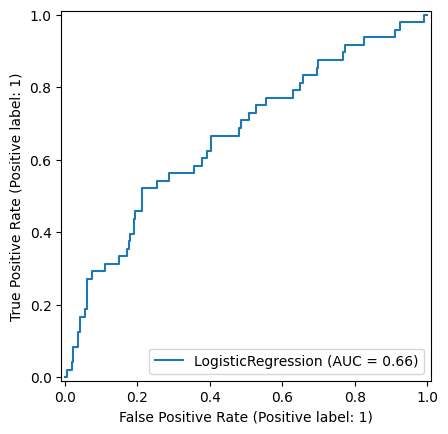

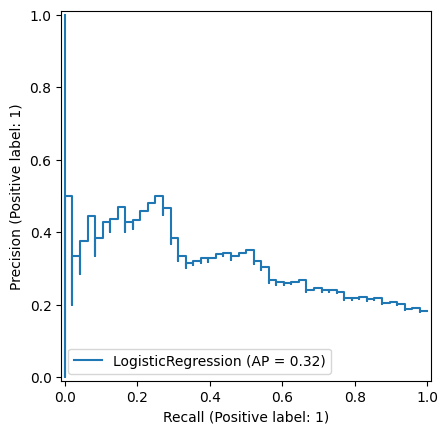

In [55]:
from sklearn.metrics import RocCurveDisplay, PrecisionRecallDisplay

RocCurveDisplay.from_estimator(
    lr_clf, X_test[selected_features], y_test.values.ravel()
)


PrecisionRecallDisplay.from_estimator(
    lr_clf, X_test[selected_features], y_test.values.ravel()
)





In [56]:
from sklearn.metrics import roc_curve

y_probs = lr_clf.predict_proba(X_test[selected_features])[:, 1]

# Compute ROC curve metrics
fpr, tpr, thresholds = roc_curve( y_test.values.ravel(), y_probs)

# Create a DataFrame to store the metrics
roc_df = pd.DataFrame({
    'False Positive Rate': fpr,
    'True Positive Rate': tpr,
    'Threshold': thresholds
})


In [57]:
roc_df.to_csv(
    "roc/sst.tsv",
    sep="\t"
)

# Probability Prediction

In [58]:
design_matrix_test = pd.read_csv(
    "../0_data/design_matrix_test.tsv",
    sep='\t'
)

design_matrix_test['sample'] = design_matrix_test['injection']
design_matrix_test['group'] = 1

quant_matrix_predict = QuantMatrix(
    quantification_file=ms_data_test,
    design_matrix_file=design_matrix_test,
    annotation_fasta_file="../0_data/2023-04-24-UP000005640.fas"
).impute(method="uniform_percentile", percentile=0.01)

predict_data, y_test_alll = quant_matrix_predict.to_ml(feature_column="ProteinLabel")

In [59]:
predict_data = predict_data[protein_columns].copy()

In [60]:
predict_data[protein_columns] = protein_scaler.transform(predict_data[protein_columns])

In [61]:
predict_data['sst_probability'] = lr_clf.predict_proba(predict_data[selected_features])[:, 1]

In [62]:
design_matrix_test = design_matrix_test.set_index("injection").join(
    predict_data['sst_probability']
).reset_index()

In [63]:
predict_data[['sst_probability']].to_csv(
    "predictions_test/sst.tsv",
    sep="\t"
)

<Axes: xlabel='sst_probability', ylabel='Count'>

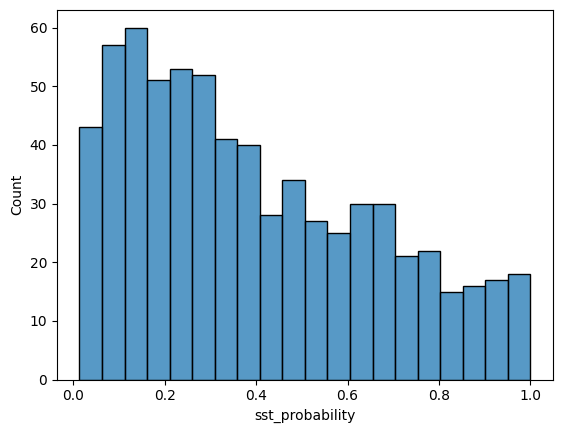

In [64]:
sns.histplot(
    data=design_matrix_test,
    x="sst_probability",
    #hue="sofa_sst_day1",
    palette="Set1", 
    #kde=True,
    multiple="stack", 
    bins=20
)

In [65]:
ms_data_val = pd.read_csv(
    "../0_data/proteins_val_filtered.tsv"
    , sep="\t"
)

design_matrix_val = pd.read_csv(
    "../0_data/design_matrix_validation.tsv",
    sep='\t'
)

design_matrix_val['sample'] = design_matrix_val['injection']
design_matrix_val['group'] = 1

quant_matrix_val = QuantMatrix(
    quantification_file=ms_data_val,
    design_matrix_file=design_matrix_val,
    annotation_fasta_file="../0_data/2023-04-24-UP000005640.fas"
)

val_data, y_val = quant_matrix_val.to_ml(feature_column="ProteinLabel")

In [66]:
val_data = val_data[protein_columns].copy()

In [67]:
val_data[protein_columns] = protein_scaler.transform(val_data[protein_columns])

In [68]:
val_data['sst_probability'] = lr_clf.predict_proba(val_data[selected_features])[:, 1]

In [69]:
design_matrix_val = design_matrix_val.set_index("injection").join(
    val_data['sst_probability']
).reset_index()

In [70]:
val_data[['sst_probability']].to_csv(
    "predictions_val/sst.tsv",
    sep="\t"
)

<Axes: xlabel='sst_probability', ylabel='Count'>

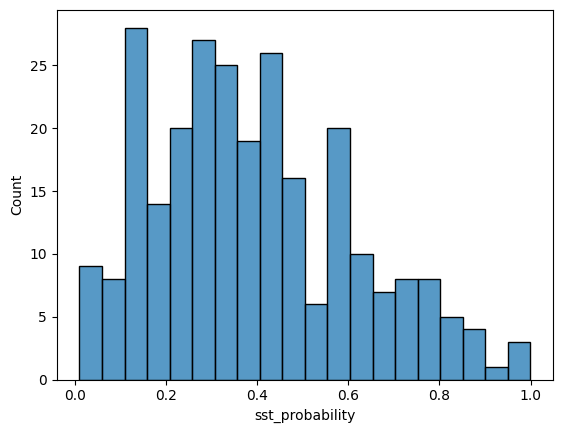

In [71]:
sns.histplot(
    data=design_matrix_val,
    x="sst_probability",
    #hue="sofa_sst_day1",
    palette="Set1", 
    #kde=True,
    multiple="stack", 
    bins=20
)

In [72]:
ms_data_hero = pd.read_csv(
    "../0_data/proteins_hero_filtered.tsv"
    , sep="\t"
)

design_matrix_hero = pd.read_csv(
    "../0_data/design_matrix_hero.tsv",
    sep='\t'
)

design_matrix_hero['sample'] = design_matrix_hero['injection']
design_matrix_hero['group'] = 1

quant_matrix_hero = QuantMatrix(
    quantification_file=ms_data_hero,
    design_matrix_file=design_matrix_hero,
    annotation_fasta_file="../0_data/2023-04-24-UP000005640.fas"
)

hero_data, y_hero = quant_matrix_hero.to_ml(feature_column="ProteinLabel")

In [73]:
hero_data = hero_data[protein_columns].copy()

In [74]:
hero_data[protein_columns] = protein_scaler.transform(hero_data[protein_columns])

In [75]:
hero_data['sst_probability'] = lr_clf.predict_proba(hero_data[selected_features])[:, 1]

In [76]:
design_matrix_hero = design_matrix_hero.set_index("injection").join(
    hero_data['sst_probability']
).reset_index()

In [77]:
hero_data[['sst_probability']].to_csv(
    "predictions_external/sst.tsv",
    sep="\t"
)

<Axes: xlabel='sst_probability', ylabel='Count'>

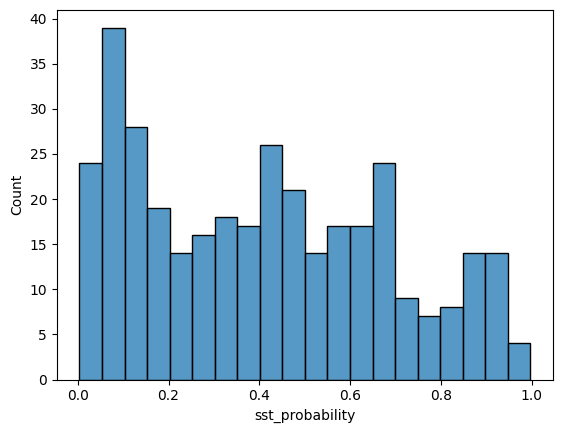

In [78]:
sns.histplot(
    data=hero_data,
    x="sst_probability",
    #hue="sofa_sst_day1",
    palette="Set1", 
    #kde=True,
    multiple="stack", 
    bins=20
)

In [79]:
from joblib import dump


with open("models/sst_protein_model.pkl", "wb") as f:

    dump(lr_clf, f)

with open("models/sst_protein_scaler.pkl", "wb") as f:

    dump(protein_scaler, f)
